<table>
 <tr align=left><td><img align=left src="https://i.creativecommons.org/l/by/4.0/88x31.png">
 <td>Text provided under a Creative Commons Attribution license, CC-BY. All code is made available under the FSF-approved MIT license. (c) Kyle T. Mandli</td>
</table>
Based on an example from https://github.com/ketch/finite-difference-course

In [1]:
%matplotlib inline
import numpy
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg

# Mixed Equations In-Class Project

Consider the reaction-diffusion PDE
$$\begin{aligned}
    u_t &= \sigma D_1 \nabla^2 u + f(u, v) \\
    v_t &= \sigma D_2 \nabla^2 v + g(u, v)
\end{aligned}$$
in two-dimensions (i.e. $\nabla^2 u = u_{xx} + u_{yy}$) and with the source terms
$$\begin{aligned}
    f(u,v) &= \alpha u (1 - \tau_1 v^2) + v (1 - \tau_2 u) \\
    g(u,v) &= \beta v + \alpha \tau_1 u v^2 + u (\gamma + \tau_2 v).
\end{aligned}$$
These equations with the appropriate parameters $\sigma, D_1, D_2, \alpha, \beta, \tau_1, \tau_2, \gamma$ can be used to study emergent patterns from seemingly random initial data which we will investigate numerically.

In [2]:
def f_reaction(U, V, sigma, tau_1, tau_2, alpha, beta, gamma):
    return alpha * U * (1.0 - tau_1 * V**2) + V * (1.0 - tau_2 * U)

def g_reaction(U, V, sigma, tau_1, tau_2, alpha, beta, gamma):
    return beta * V * (1.0 + alpha * tau_1 / beta * U * V) + U * (gamma + tau_2 * V)

## Spatial Derivative Discretization

Let's consider the above PDEs on the a square domain $\Omega = [-1, 1] \times [-1, 1]$ with periodic boundary conditions.  First write a function that uses a five-point stencil to represent the Laplacian operator in 2d and returns the appropriate sparse matrix reprsentation.

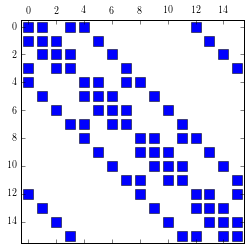

In [3]:
def laplacian_discretization(m):
    """Constructs a sparse matrix that discretizes the 2d Laplacian
    
    Uses a five-point stencil and periodic boundary conditions.
    """
    delta_x = 2.0 / (m + 1)
    
    # Primary discretization
    e = numpy.ones(m)
    T = sparse.spdiags([e, -4.0 * e, e], [-1, 0, 1], m, m)
    S = sparse.spdiags([e, e], [-1, 1], m, m)
    I = sparse.eye(m)
    A = sparse.kron(I, T) + sparse.kron(S, I)
    
    # Construct periodic BCs
    e = numpy.ones(m**2)
    A_periodic = sparse.spdiags([e, e],[m - m**2, m**2 - m], m**2, m**2).tolil()
    # Left & right BCs:
    for i in range(m):
        A_periodic[i * m, (i + 1) * m - 1] = 1.0
        A_periodic[(i + 1) * m - 1, i * m] = 1.0
    
    # Combine two matrices
    A = A + A_periodic
    A /= delta_x**2
    A = A.todia()
    
    return A

A = laplacian_discretization(4)
plt.spy(A)
plt.show()

## Time Stepping

First let's see if we can make a simple explicit method, in this case forward Euler, work for us.  We know this might not be such as great idea due to the diffusion term but maybe the reaction terms will be helpfull.

First write a function that uses forward Euler to take a single time step to solve the equations of interest.

In [8]:
def forward_euler_step(U, V, delta_t, A, sigma, f, g, D1=0.5, D2=1.0):
    """Take a single forward Euler step on the reaction-diffusion equation"""
    
    U_new = U + delta_t * (sigma * D1 * A * U + f(U, V))
    V_new = V + delta_t * (sigma * D2 * A * V + g(U, V))
    
    return U_new, V_new

Let's now try to solve the PDE given the parameters
$$
    \sigma = 0.0021, ~ \tau_1 = 3.5, ~ \tau_2 = 0.0, ~ \alpha = 0.899, ~ \beta=-0.91, ~\gamma=-\alpha
$$
with the default values of $D_1 = 0.5$ and $D_2 = 1.0$.  We will also take a random initial condition.

Note what step-size we might need here.  For the two-dimensional heat equation we can show that forward Euler is going to require a step size of
$$
    \Delta t \leq \frac{\Delta x^2}{4 \kappa}
$$
where now $\kappa$ is the coefficient out in front of the Laplacian.  Here we will take the maximum of the coefficient in front of the Laplacians to remain stable.

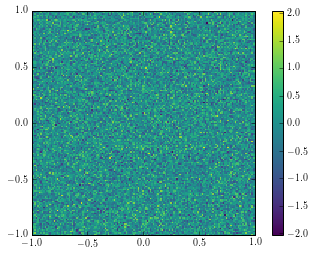

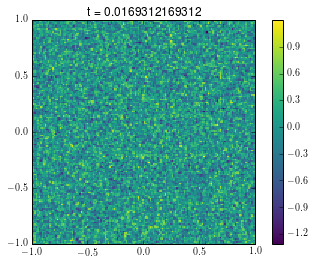

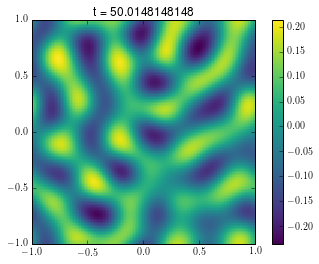

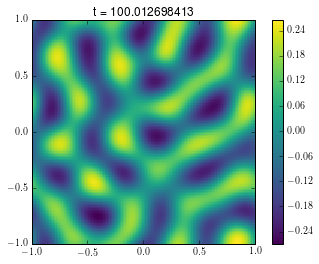

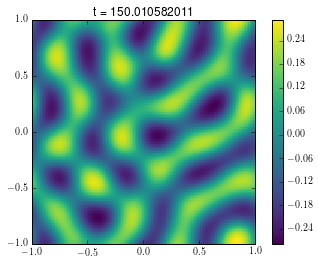

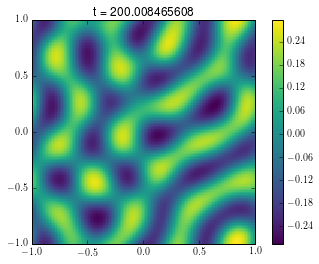

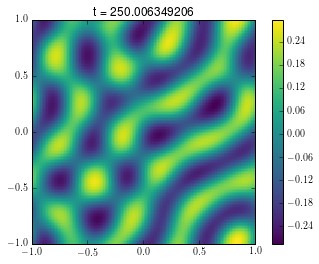

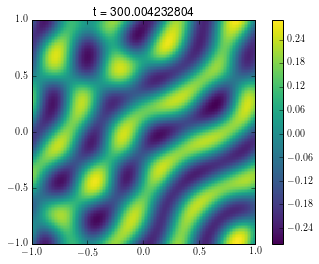

In [9]:
def forward_euler_coupled_solver(sigma, tau_1, tau_2, alpha, beta, gamma, D_1, D_2):
    # Alias reaction functions with the above parameters
    f = lambda U, V: f_reaction(U, V, sigma, tau_1, tau_2, alpha, beta, gamma)
    g = lambda U, V: g_reaction(U, V, sigma, tau_1, tau_2, alpha, beta, gamma)

    # Set up grid
    m = 150
    delta_x = 2.0 / m
    x = numpy.linspace(-1.0, 1.0, m)
    y = numpy.linspace(-1.0, 1.0, m)
    Y, X = numpy.meshgrid(y, x)

    # Initial data
    U = numpy.random.randn(m, m) / 2.0
    V = numpy.random.randn(m, m) / 2.0
    fig = plt.figure()
    axes = fig.add_subplot(1, 1, 1, aspect='equal')
    plot = axes.pcolor(x, y, U, cmap=plt.get_cmap("viridis"))
    fig.colorbar(plot)

    # Setup spatial discretization
    U = U.reshape(-1)
    V = V.reshape(-1)
    A = laplacian_discretization(m)

    # Time
    t = 0.0
    t_final = 300.0
    delta_t = delta_x**2 / (5.0 * sigma)
    num_steps = int(numpy.round(t_final / delta_t))

    # Evolve in time
    next_output_time = 0.0
    for j in xrange(num_steps):
        U, V = forward_euler_step(U, V, delta_t, A, sigma, f, g)
        t += delta_t

        if t >= next_output_time:
            next_output_time += 50.0
            U_output = U.reshape((m, m))

            fig = plt.figure()
            axes = fig.add_subplot(1, 1, 1, aspect='equal')
            plot = axes.pcolor(x, y, U_output, cmap=plt.get_cmap("viridis"))
            fig.colorbar(plot)
            axes.set_title("t = %s" % t)

    plt.show()
    
forward_euler_coupled_solver(sigma=0.0021, tau_1=3.5, tau_2=0, alpha=0.899, beta=-0.91, gamma=-0.899, D_1=0.5, D_2=1.0)

### Implicit-Explicit Splitting

The previous approach was clearly very slow so let's try applying one of our splitting techniques to the problem instead.  IMEX methods are actually pretty ideal for this case so let's try using backwards Euler for the stiff diffusion term and the forward Euler time step for the explicit reaction terms.

Implicit:
$$\begin{aligned}
    u_t &= \sigma D_1 \nabla^2 u \\
    v_t &= \sigma D_2 \nabla^2 v
\end{aligned}$$

Explicit:
$$\begin{aligned}
    u_t &= f(u, v) \\
    v_t &= g(u, v)
\end{aligned}$$

Numerical method:
$$\begin{aligned}
    U^\ast &= U^n + \Delta t \sigma D_1 \nabla^2 U^\ast \\
    V^\ast &= V^n + \Delta t \sigma D_2 \nabla^2 V^\ast \\
    U^{n+1} &= U^\ast + \Delta t f(U^\ast, V^\ast) \\
    V^{n+1} &= V^\ast + \Delta t g(U^\ast, V^\ast) \\
\end{aligned}$$

In [13]:
def backward_euler_diffusion_step(U, V, A, delta_t, sigma, D_1, D_2):
    U = linalg.spsolve((sparse.eye(A.shape[0]) - delta_t * sigma * D_1 * A), U)
    V = linalg.spsolve((sparse.eye(A.shape[0]) - delta_t * sigma * D_2 * A), V)
    return U, V

def forward_euler_reaction_step(U, V, delta_t, f, g):
    U_new = U + delta_t * f(U, V)
    V_new = V + delta_t * g(U, V)
    return U_new, V_new

In [ ]:
def imex_solver(sigma, tau_1, tau_2, alpha, beta, gamma, D_1, D_2):
    # Alias reaction functions with the above parameters
    f = lambda U, V: f_reaction(U, V, sigma, tau_1, tau_2, alpha, beta, gamma)
    g = lambda U, V: g_reaction(U, V, sigma, tau_1, tau_2, alpha, beta, gamma)

    # Set up grid
    m = 150
    delta_x = 2.0 / m
    x = numpy.linspace(-1.0, 1.0, m)
    y = numpy.linspace(-1.0, 1.0, m)
    Y, X = numpy.meshgrid(y, x)

    # Initial data
    U = numpy.random.randn(m, m) / 2.0
    V = numpy.random.randn(m, m) / 2.0
    fig = plt.figure()
    axes = fig.add_subplot(1, 1, 1, aspect='equal')
    plot = axes.pcolor(x, y, U, cmap=plt.get_cmap("viridis"))
    fig.colorbar(plot)

    # Setup spatial discretization
    U = U.reshape(-1)
    V = V.reshape(-1)
    A = laplacian_discretization(m)

    # Time
    t = 0.0
    t_final = 30.0
    delta_t = delta_x / (10.0 * sigma)
    num_steps = int(numpy.round(t_final / delta_t))

    # Evolve in time
    next_output_time = 0.0
    for j in xrange(num_steps):
        U, V = backward_euler_diffusion_step(U, V, A, delta_t, sigma, D_1, D_2)
        U, V = forward_euler_step(U, V, delta_t, A, sigma, f, g)
        t += delta_t

        if t >= next_output_time:
            next_output_time += 5.0
            U_output = U.reshape((m, m))

            fig = plt.figure()
            axes = fig.add_subplot(1, 1, 1, aspect='equal')
            plot = axes.pcolor(x, y, U_output, cmap=plt.get_cmap("viridis"))
            fig.colorbar(plot)
            axes.set_title("t = %s" % t)

    plt.show()
    
# Parameters
imex_solver(sigma=0.0021, tau_1=3.5, tau_2=0, alpha=0.899, beta=-0.91, gamma=-0.899, D_1=0.5, D_2=1.0)

Try playing with the input parameters and see what kind of behavior you see.

In [ ]:
sigma=0.0045; tau1=2.02; tau2=0.; alpha=2.0; beta=-0.91; gamma=-alpha;
sigma=0.0005; tau1=2.02; tau2=0.; alpha=2.0; beta=-0.91; gamma=-alpha;
sigma=0.0021; tau1=3.5; tau2=0; alpha=0.899; beta=-0.91; gamma=-alpha;
sigma=0.0045; tau1=0.02; tau2=0.2; alpha=1.9; beta=-0.85; gamma=-alpha;
sigma=0.0001; tau1=0.02; tau2=0.2; alpha=0.899; beta=-0.91; gamma=-alpha;
sigma=0.0045; tau1=0.02; tau2=0.2; alpha=1.9; beta=-0.91; gamma=-alpha;